# Лабораторная работа 1. Нейронные сети.

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете также должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

Мы уверены, что выполнение лабораторных работ занимает значительное время, поэтому не рекомендуем оставлять их на последний вечер перед сдачей.

### Оценивание и штрафы
* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за всю работу — 15 баллов
* Сдавать задание после указанного срока сдачи нельзя
* «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса)
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировкам
* Не оценивается лабораторная работа целиком, если она была выложена в открытый источник

Обратите внимание, что мы не ставим оценку за просто написанный код, корректная работоспособность которого не подтверждена экспериментами.

### Правила сдачи
Выполненную работу следует отправить в систему Anytask. Более подробно о системе можно почитать на странице курса. Название отправляемого файла должно иметь следующий формат: Surname_Name_Group_NN.ipynb, где NN — номер лабораторной работы. Например, Kozlova_Anna_CS_01.ipynb.

# Часть 3. Рекуррентные языковые модели

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSj85jp-W-V-Bz8ZBjFJYIkV1TTxQxTMh4iqls_rRt8O-sraL08PA)

В этой части домашней работы мы создадим языковую модель на рекуррентных нейросетях (RNN) и заставим её придумывать имена.

__Языковая модель__, если вкратце, это модель, которая умеет как предсказывать вероятность некоторого текста. Ее можно использовать также чтобы генерировать текст в соответствии с обученными вероятностями. Задание будет заключаться в том, чтобы научить модель генерировать новые имена, скормив ей для этого 8к существующих.

В данном случае в качестве входных данных мы будет работать со строками, которые можно рассматривать как последовательности _символов_: $\{x_0, x_1, x_2, ..., x_n\}$. 

Наша основная задача — научиться предсказывать вероятность следующего символа:
$$ p(x_0, x_1, x_2, ..., x_n) = \prod_t p(x_t | x_0, ... x_{t - 1}) $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Данные

Мы будем строить языковую модель по ~8k человеческих имён на латинице. Если когда-нибудь вам нужно будет дать имя своему ребёнку, у вас будет для этого генеративная нейросетевая модель.

Давайте их прочитаем:
* Считайте все строки из файла `./names` в список
* В начало каждой строки допишите __пробел__
* В конце сроки не должно быть переноса (`\n`)

In [2]:
import os
start_token = " "

# YOUR CODE
lines = [' ' + i.rstrip() for i in open('./names').readlines()]

In [3]:
assert all(line[0] == start_token for line in lines)
assert all(line[-1] != '\n' for line in lines)

In [4]:
print ('n samples = ',len(lines))
for x in lines[::1000]:
    print (x)

n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


Проверьте, что все корректно:

In [5]:
MAX_LENGTH = max(map(len, lines))
print("max length =", MAX_LENGTH)
assert MAX_LENGTH == 16 , "max length (for names) should be 16. remove assert if you work on different dataset"

max length = 16


## Словари

В начале нам будет необходимо построить "словарь" — упорядоченное множество уникальных символов, которые сеть может породить. Это нужно, чтобы уметь сопоставить каждому символу свой номер. Перед отправкой в сеть все символы будут кодироваться их номерами в словаре.

Также необходимо добавить в словарь пробельный символ, который будет использоваться в качестве специального токена.

In [6]:
tokens = list(set(list(''.join(lines))))#YOUR CODE

tokens = sorted(list(tokens))

n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)

assert 50 < n_tokens < 60

n_tokens =  55


А теперь построим обратный словарь: для каждой буквы посчитаем её номер в списке токенов.

In [7]:
token_to_id = {j: i for i, j in enumerate(tokens)}

И проверим, все ли корректно:

In [8]:
assert len(tokens) == len(token_to_id), "число токенов должно совпадать"

for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "словарь должен указывать на индекс буквы в tokens"

print("Кажется заработало...")

Кажется заработало...


Имея построенное соответствие, можно преобразовать батч входных данных в матрицу int32 номеров токенов. Так как в батче все строки должны быть одной длины, слишком короткие строки в батче нужно будет дополнить пробелами (паддинг).

In [9]:
def to_matrix(lines, max_len=None, pad=token_to_id[' '], dtype='int32'):
    """Casts a list of names into rnn-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad

    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i]))
        lines_ix[i, :len(line_ix)] = line_ix

    return lines_ix

In [10]:
print('\n'.join(lines[::2000]))
print(to_matrix(lines[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne
[[ 0  3 30 29 35 29 33 40  0]
 [ 0  9 40 43 46 53  0  0  0]
 [ 0 18 46 37 47 47 37 33  0]
 [ 0  9 37 43 50 29 42 42 33]]


## Один шаг RNN

Рекуррентная нейронная сеть (RNN) — это такая сеть с <s>блокнотом</s> состоянием $h$, в который она умеет писать то, что видела.

Сеть начинает с пустого $h_0 = \vec 0$, после чего текст обрабатывается по одному символу:
* $x_t$ — очередной символ, $h_t$ — предыдущее состояние
* $h_{t+1} = \text{get_h_next}(h_t, x_t)$ — новое состояние
* $p(x_{t+1} | h_{t+1}) = \text{get_probs}(h_{t+1})$ — вероятность следующего символа



<img src="https://i.imgur.com/8l4qFF0.png" width=480>

Поскольку $x_t$ это индекс символа в словаре (=натуральное число), то ему можно сопоставить некоторый обучаемый вектор (*embedding*).

**Задание 3.1 (0.75 балла)**. Реализуйте вычисление нового состояния *get_h_next* и вероятности следующего символа *get_probs*, после чего напишите код для одного шага рекуррентной сети *rnn_one_step*, как на схеме выше.

In [11]:
import tensorflow as tf
import keras, keras.layers as L

emb_size, rnn_size = 16, 64

Using TensorFlow backend.


Создадим слой, который сопоставляет каждому из n_tokens входов свой обучаемый вектор:

In [12]:
embed_x = L.Embedding(n_tokens, emb_size)

Теперь инициализируем слой, вычисляющий следующее состояния $[emb(x_t), h_t] \to h_{t+1}$.

In [13]:
get_h_next = L.Dense(rnn_size, activation="relu") # YOUR CODE

И, наконец, слой предсказывающий вероятности $h_{t+1} \to P(x_{t+1}|h_{t+1})$.

In [14]:
get_probs = L.Dense(n_tokens, activation='softmax')# YOUR CODE

Для реализации одного шага RNN реализуйте следующую последовательность действий:
1. замените номер символа на его вектор (embedding) (*hint*: возможно, вам потребуется tf.reshape);
2. сконкатенируйте вектор входа и предыдущее состояние;
3. вычислите следующее состояние сети;
4. предскажите вероятности для языковой модели P(x_next | h_next).

In [15]:
def rnn_one_step(x_t, h_t):  
    
    # YOUR CODE
    print(tf.reshape(x_t,[-1,1]))
    x_t_emb = embed_x(tf.reshape(x_t,[-1,1]))[:,0]
    x_and_h = tf.concat([x_t_emb, h_t], 1)
    h_next = get_h_next(x_and_h)
    output_probs = get_probs(h_next)
    return h_next, output_probs

Проверим, что все работает:

In [16]:
input_sequence = tf.placeholder('int32', (None, MAX_LENGTH))
batch_size = tf.shape(input_sequence)[0]

# начальное состояние из нулей
h0 = tf.zeros([batch_size, rnn_size])

In [17]:
h1, p_y1 = rnn_one_step(input_sequence[:, 0], h0)

dummy_data = np.arange(MAX_LENGTH * 2).reshape([2, -1])
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
test_h1, test_p_y1 = sess.run([h1, p_y1],  {input_sequence: dummy_data})

assert test_h1.shape == (len(dummy_data), rnn_size)
assert test_p_y1.shape == (len(dummy_data), n_tokens) and np.allclose(test_p_y1.sum(-1), 1)

Tensor("Reshape:0", shape=(?, 1), dtype=int32)


## Много шагов RNN

После того как был реализован один шаг нейросети, самое время сделать этих шагов побольше. Самый простой способ это сделать — написать цикл для фиксированного числа шагов (`MAX_LENGTH`).

**Задание 3.2 (0.25 балла)**. Реализуйте много шагов рекуррентной сети, на каждом шаге вычисляя следующее состояние RNN, исходя из предыдущего, при этом не забывая про *get_h_next* и *get_probs*.

In [18]:
h_prev = h0
predicted_probs = []

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]
    # YOUR CODE
    probs_next, h_next = rnn_one_step(x_t,h_prev)
    
    # END OF YOUR CODE
    predicted_probs.append(probs_next)
    h_prev = h_next
    
predicted_probs = tf.stack(predicted_probs, axis=1)

Tensor("Reshape_2:0", shape=(?, 1), dtype=int32)
Tensor("Reshape_4:0", shape=(?, 1), dtype=int32)


ValueError: Input 0 is incompatible with layer dense_1: expected axis -1 of input shape to have value 80 but got shape (None, 71)

In [19]:
assert predicted_probs.shape.as_list() == [None, MAX_LENGTH, n_tokens]
assert h_prev.shape.as_list() == h0.shape.as_list()

AttributeError: 'list' object has no attribute 'shape'

## Обучение RNN

Как и любую вероятностную модель, RNN можно обучить методом максимизации log-правдоподобия по всей выборке $D$:

$$ \theta = \underset \theta {argmax} \log P(D) $$

где
$$ \log P(D) = \underset {\vec x \in D} \sum \log P(\vec x) = \underset {\vec x \in D} \sum \underset {x_t \in \vec x} \sum \log P(x_t | x_0, ..., x_{t+1})$$

C тем же успехом мы можем __минимизировать__ кроссэнтропию — то же самое, но с минусом.

In [20]:
predictions_matrix = predicted_probs[:, :-1]
answers_matrix = tf.one_hot(input_sequence[:, 1:], n_tokens)

print('predictions_matrix:', predictions_matrix.shape)
print('answers_matrix:', predictions_matrix.shape)

TypeError: list indices must be integers or slices, not tuple

**Задание 3.3 (0.5 балла)**. Реализуйте вычисление функции потерь (кроссэнтропия) и шаг градиентного спуска.

In [21]:
from keras.objectives import categorical_crossentropy

loss = tf.reduce_mean(categorical_crossentropy(answers_matrix, predictions_matrix))# YOUR CODE

optimize = tf.train.AdamOptimizer().minimize(loss) # YOUR CODE

NameError: name 'answers_matrix' is not defined

### Цикл обучения

**Задание 3.4 (0.5 балла)**. Напишите цикл обучения:
1. выбираем `batch_size` случайных строчек
2. преобразуем их в матрицу индексов
3. вычисляем функцию потерь и делаем шаг обучения
4. записываем функцию потерь в `history`

Для удобства отладки рекомендуем печатать или рисовать промежуточные результаты раз в несколько итераций.

Также постарайтесь обойтись одним `sess.run` на итерацию цикла.

In [22]:
batch_size = 32
history = []

sess.run(tf.global_variables_initializer())

In [23]:
from random import sample

for i in range(1000):
    # YOUR CODE HERE
    batch = to_matrix(sample(names,32),max_len=MAX_LENGTH)
    loss_i,_ = s.run([loss,optimize],{input_sequence:batch})
    
    
    history.append(loss_i)

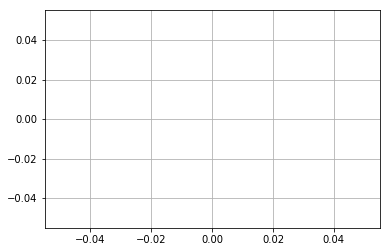

In [24]:
plt.plot(history)
plt.grid()

## Применение RNN

Только что у нас обучилась модель, которая предсказывает вероятности следующего символа.
Теперь давайте применим её к строке из одного пробела. Получим вероятности первой буквы имени. После чего:
* $x_t \sim P(x_t | h_t)$ — выберем букву пропорционально вероятностям.
* $h_{t+1} = \text{get_h_next}(h_t, x_t)$ — присоединим букву к имени и прогоним через RNN


Для начала инициализируем необходимые переменные:

In [25]:
x_t = tf.placeholder('int32', (None,))
h_t = tf.Variable(np.zeros([1, rnn_size], 'float32'))

next_h, next_probs = rnn_one_step(x_t, h_t)

Tensor("Reshape_6:0", shape=(?, 1), dtype=int32)


И будем использовать функцию ниже для генерации новых имен!

In [26]:
def generate_sample(seed_phrase=' ', max_length=MAX_LENGTH):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    sess.run(tf.variables_initializer([h_t]))
    
    #feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         sess.run(tf.assign(h_t, next_h), {x_t: [ix]})
    
    #start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs, _ = sess.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence])

Посмотрим, что же придумала наша модель:

In [27]:
for _ in range(10):
    print(generate_sample())

 KdPVZEECYgNBvHu
  FhwEHAPQZLCNzJ
 U'VPPlohlDcLYpl
 aYGjxaKbS'tknLi
 TpTKSMjIKFLxaxJ
 aXFDy'DroSyGNeK
 xGogaJyRgINvGxF
 AghooahVQPPaxRt
 dKBlnFKWGqgarMH
 EpLIqpiRpBpEVsA


In [28]:
for _ in range(50):
    print(generate_sample(' Trump'))

 Trumph'PUaLkTRK
 TrumpNOrIGIMfQ-
 TrumphEruNKCZPw
 TrumpdfGJztxSlV
 TrumpgCigQDpnDf
 TrumpIHpPKZKuVE
 TrumpMIauyLoQuj
 Trump'PhrNvBPnZ
 TrumpDUpXKJMh-X
 TrumpJYgTEPbgCS
 TrumpZrIHIYmHlT
 TrumpozHcZUWIxI
 TrumpqGNDUF pph
 TrumpkqFVTlhkzc
 TrumpNclGOYeqMt
 TrumpKTDHwqlKwr
 TrumpIGTqLU-CjS
 Trumpt-vYhJLRoX
 Trumpej'SebhauU
 TrumpFawdHuY-xn
 TrumpCoxDSVmnzA
 TrumpyKXLZbTo'F
 TrumpkFoDwKhdew
 TrumpXnMZuqaHkM
 TrumpZoBKTW Ehq
 TrumphYrWhKC'pl
 TrumpHdKCZcynti
 TrumpaLYxMDqykt
 TrumpiGOwylGXTy
 TrumpepLGucbfEX
 TrumpmRhHsDtTxw
 TrumpFwRn-RZtkS
 TrumpwxvMPkAGFG
 TrumprGAhQurWZr
 TrumpmL sSaJkin
 TrumpUuQlrxDUj 
 TrumpSjirOmUX'S
 TrumpmmnOmgmKFw
 TrumpH-uamwgZjh
 TrumpVDb'BpkkQN
 TrumpWuVDR'y'rZ
 TrumpAd bv tRRg
 TrumpDNTcvqlRGu
 TrumpmlHZxUGhnm
 TrumpPzlUCeAgJ-
 TrumpMMupIoURZM
 TrumpOjQcprVGWS
 TrumpfoLoopaGIa
 TrumpNBxxWpSmNY
 TrumpTR-wXOPZL 


### Что теперь?

Если вам наскучит решать повседневные задачи или вам нужны новые идеи, вы теперь всегда можете воспользоваться RNN чтобы сгенерировать что-то новое. Вот несколько задач, от которых можно отталкиваться:
* названия статей по глубинному обучению;
* названия карт Magic The Gathering;
* [имена покемонов](https://github.com/cervoise/pentest-scripts/blob/master/password-cracking/wordlists/pokemon-list-en.txt);
* clickbait заголовки;
* молекулы в формате [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system);
* ваша фантазия, с ограничениями которой вы уже должны были понять как бороться.

Если возьмётесь за эту задачу, то вот несколько полезных советов:
* Сейчас модель обучается на коротких строчках. Если у вас роман, его придётся порезать на кускочки.
* Если длина строк сильно варьируется, можно поставить параметр MAX_LENGTH так, чтобы он покрывал 90%. Это обычно дает ускорение примерно в 2 раза.
* Для более сложных задач требуется больше нейронов (rnn_size). Кроме того, можно экспериментировать и со составляющими сети (см. ниже).

### Ещё почитать

* [Подборка советов](https://danijar.com/tips-for-training-recurrent-neural-networks/) по обучению RNN. Чуть более полезная, чем обычно.
* Отличный блог-пост от Andrej Karpathy про языковые модели на rnn, их применение и визуализацию — [Unreasonable Effectiveness of RNN](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).
* Большой список статей, постов, реализаций и прочих полезностей по RNN - [awesome rnn](https://github.com/kjw0612/awesome-rnn).
* [Зоопарк](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn) готовых рекуррентных ячеек (LSTM, GRU) в TF. И ещё одна реализация [в карасе](https://keras.io/layers/recurrent/).
* Сейчас мы настраиваем количество итераций заранее. Если вы хотите определять их динамически, милости просим в [tf.while_loop](https://www.tensorflow.org/api_docs/python/tf/while_loop) или [tf.scan](https://www.tensorflow.org/api_docs/python/tf/scan).
* А ещё рекуррентные сети можно аугментировать механизмом внимания или долговременной памятью. Вот тут есть [хорошая статья](https://distill.pub/2016/augmented-rnns/).